# Important

**Pour les analyse et les interpretation, nous vous prions de consulter le rapport PDF** 

# import package

In [1]:
# package pour le traitement des données
import pandas as pd 
import numpy as np
from numpy import log


# package pour les visualisations graphiques
import plotly.express as px
import plotly.graph_objects as go 
import matplotlib.pyplot as plt 


# package pour les traitement des données temporel (model, lissage, test)
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


# package pour determoner les coeff de nos regression (machine learning)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Partie 1

## init data

In [2]:
df = pd.read_csv("data/valeurs_mensuelles.csv", sep=";").iloc[3:,0:2].sort_values(by="Libellé").reset_index(drop=True).rename(columns={"Libellé" : "date", 
                        "Indice de prix de production de l'industrie française pour le marché français − CPF 35.11 et 35.14 − Électricité tarif de détail pour les ménages " : "valeur"})

df["valeur"] = df["valeur"].astype("float") 
df["ln(x)"] = np.log(df["valeur"])

df.head()

px.line(x = df.index, y = df["valeur"])

## etablissement CVS et prévision

### etablissement CVS

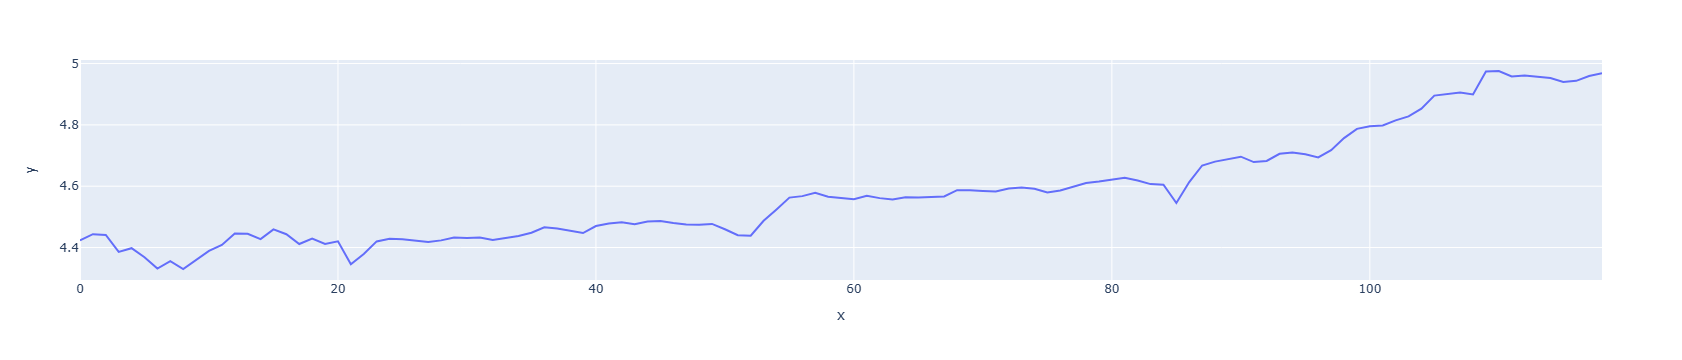

In [3]:
result_decompose = seasonal_decompose(df["ln(x)"], model="additive", period=12)

df["trend"] = result_decompose.trend
df["error"] = result_decompose.resid
df["seasonal"] = result_decompose.seasonal 
df["cvs"] = df["ln(x)"] - df["seasonal"]

px.line(x = df.index, y = df["cvs"])

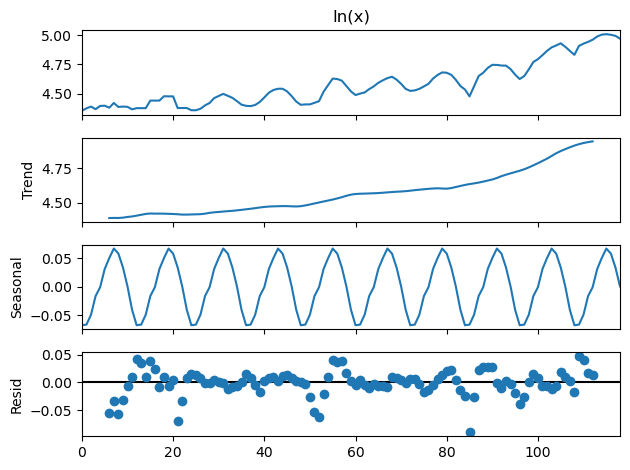

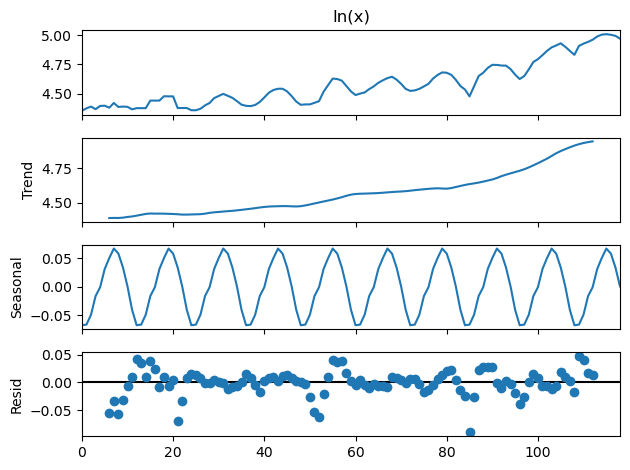

In [4]:
result_decompose.plot()

### modélisation avec methode moindre carré (expo et polynomial)

In [5]:
# method exponentiel 

#----------------------------------------------- entrainement model ----------------------------------------
data = df["cvs"].to_frame()
data["x"] = data.index + 1
data["ln(cvs)"] = np.log(data["cvs"])

x = np.array(data["x"]).reshape(-1, 1)
y = np.array(data["ln(cvs)"]).reshape(-1, 1)

model_expo = LinearRegression()
model_expo.fit(x, y)

# --------------------------------------- calcul score R² -----------------------------------------------------------
pred = model_expo.predict(x)
score = r2_score(y, pred)
print(score)

# ------------------------------------- resultat ----------------------------------------------------------------------
a = model_expo.coef_[0][0] 
b = np.e ** model_expo.intercept_[0] 
print(f""" les paramètre sont  : 
            a = {a} 
            b = {b} 
            R² = {score}""")

data["expo_pred"] = courbe = b * (np.e**(a*x))

graph = go.Figure()
graph.add_trace(go.Scatter(x = data["x"], y = data["cvs"], mode='lines', name='CVS'))
graph.add_trace(go.Scatter(x = data["x"], y = data["expo_pred"], mode='lines', name='expo_predict'))
graph.show()

0.8749599936035033
 les paramètre sont  : 
            a = 0.0010256876502071598 
            b = 4.302844065235247 
            R² = 0.8749599936035033


In [6]:
# method puissance (ax²+bx+c)

#----------------------------------------------- entrainement model ----------------------------------------
data["x²"] = data["x"]**2

x = data[["x²", "x"]]
y = np.array(data["cvs"]).reshape(-1, 1)

model_poly = LinearRegression()
model_poly.fit(x, y)

# --------------------------------------- calcul score R² -----------------------------------------------------------
pred = model_poly.predict(x)

score = r2_score(y, pred)
print(score)

# ------------------------------------- resultat ----------------------------------------------------------------------
print(f""" les paramètre sont  : 
            a = {model_poly.coef_} 
            b = {model_poly.intercept_} 
            R² = {score}""")
a = model_poly.coef_[0][0]
b = model_poly.coef_[0][1]
c = model_poly.intercept_

data["poly_pred"] = a*data["x²"] + b*data["x"] + c

graph.add_trace(go.Scatter(x = data["x"], y = data["poly_pred"], mode='lines', name='poly_predict'))
graph.show()

0.9579354109514685
 les paramètre sont  : 
            a = [[ 5.03466779e-05 -1.29558384e-03]] 
            b = [4.41632332] 
            R² = 0.9579354109514685


### lissage exponnentiel

{'smoothing_level': 0.9999999850988388, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 4.4231901188283915, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


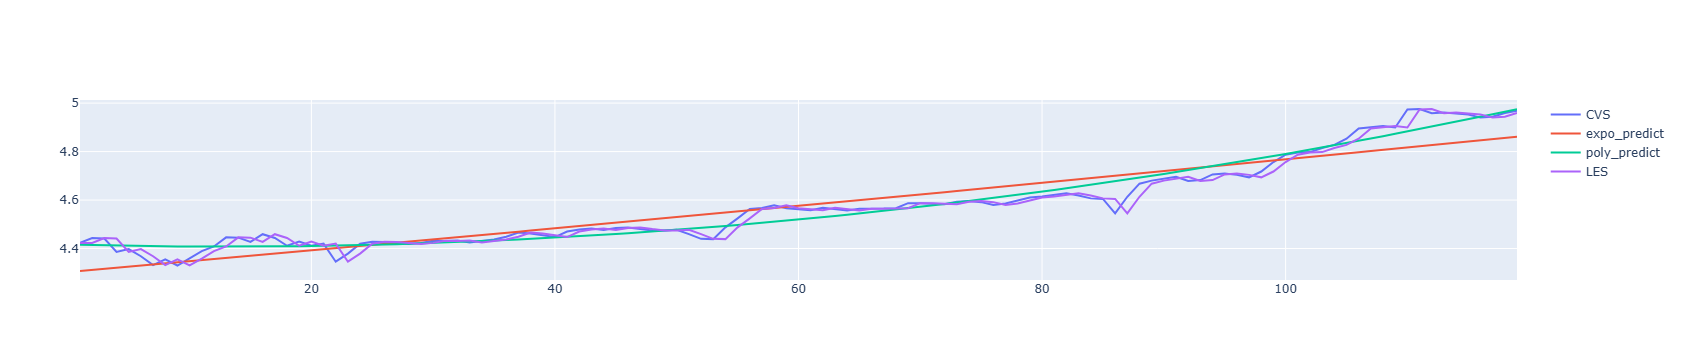

{'smoothing_level': 0.3, 'smoothing_trend': 0.1, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 4.414209655526887, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


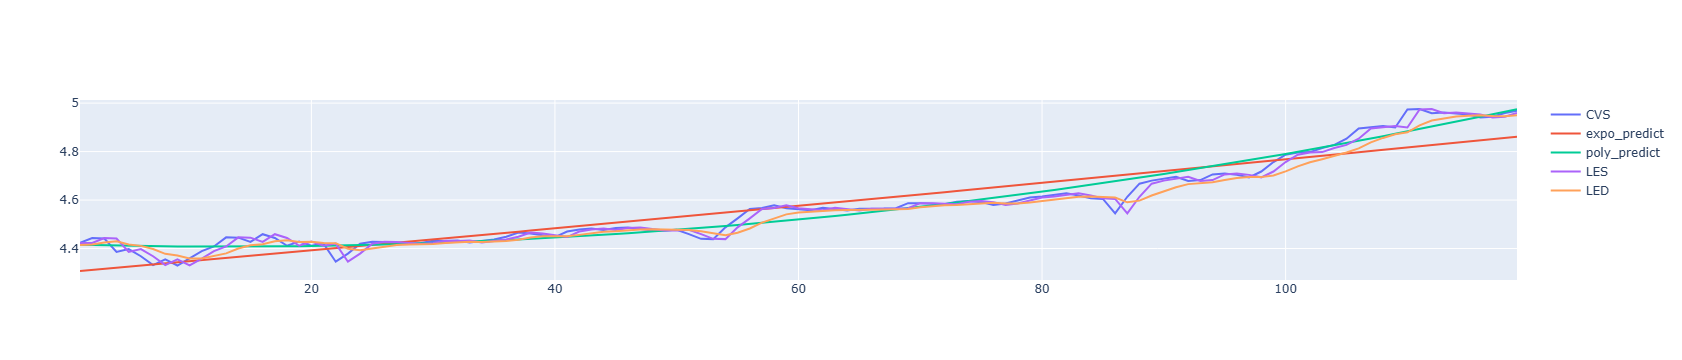

In [7]:
#--------------------------------------------- Lissage simple --------------------------------------------

les = SimpleExpSmoothing(data["cvs"])
les = les.fit(optimized=True)

data["les"] = les.fittedvalues
print(les.params)

graph.add_trace(go.Scatter(x = data["x"], y = data["les"], mode='lines', name='LES'))
graph.show()


# --------------------------------------------- lissage double ----------------------------------------------
led = ExponentialSmoothing(data["cvs"])
led = led.fit(smoothing_level=0.3, smoothing_trend=0.1, optimized=True)

data["led"] = led.fittedvalues
print(led.params)

graph.add_trace(go.Scatter(x = data["x"], y = data["led"], mode='lines', name='LED'))
graph.show()

## tracer de la composante saisoniere

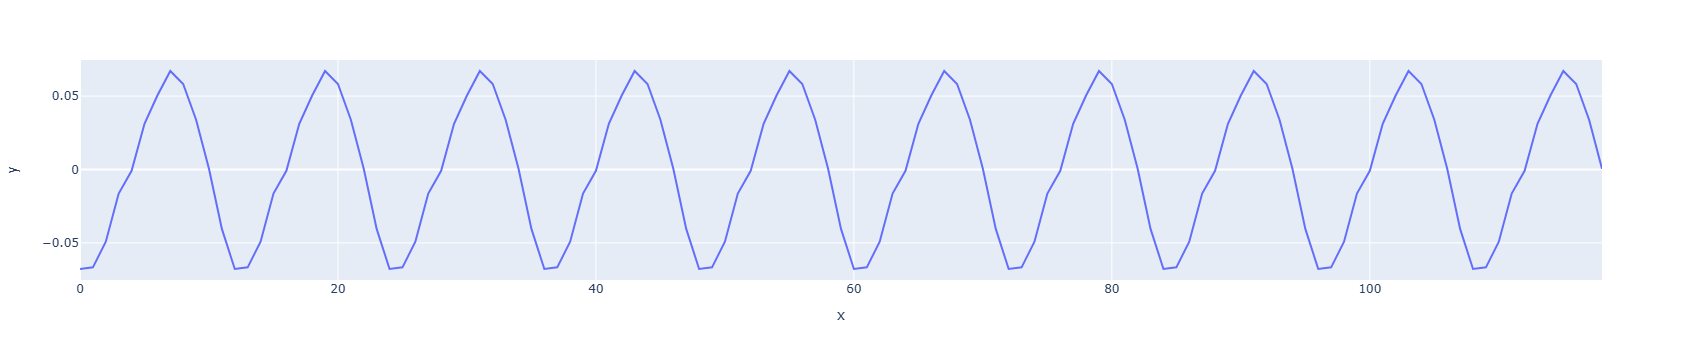

In [8]:
px.line(x = df.index, y = df["seasonal"])

# Partie 2

## test adfuller et choix de d

Ici nous visualisation notre série sans aucune transformation

In [9]:
df = pd.read_csv("data/dataset.csv")

df.plot()

<Axes: >

Ici nous visualisont notre série passez au logarithme pour la transformé en série additive et rendre la **variance stationnaire**

In [10]:
df['value'] = log(df["value"])

df.plot()

<Axes: >

Test de ADFuller

ADF Statistic: -0.988733
p-value: 0.757351


différention (1) : ADF Statistic: -4.519432
différention (1) : p-value: 0.000181


différention (2) : ADF Statistic: -10.037294
différention (2) : p-value: 0.000000


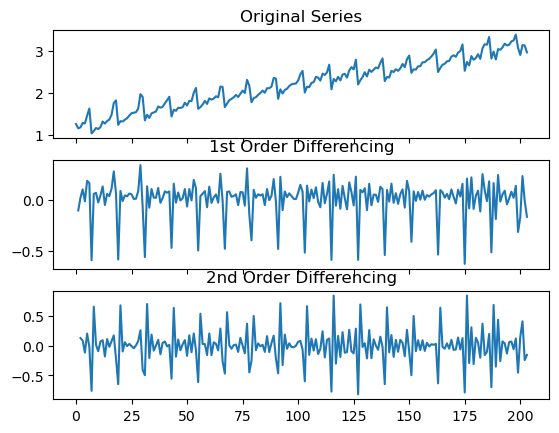

In [11]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print("\n")

result = adfuller(df.value.diff().dropna())
print('différention (1) : ADF Statistic: %f' % result[0])
print('différention (1) : p-value: %f' % result[1])


print("\n")

result = adfuller(df.value.diff().diff().dropna())
print('différention (2) : ADF Statistic: %f' % result[0])
print('différention (2) : p-value: %f' % result[1])

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(df.value); axes[0].set_title('Original Series')

# 1st Differencing
axes[1].plot(df.value.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df.value.diff().diff()); axes[2].set_title('2nd Order Differencing')

plt.show()

## choix de p 

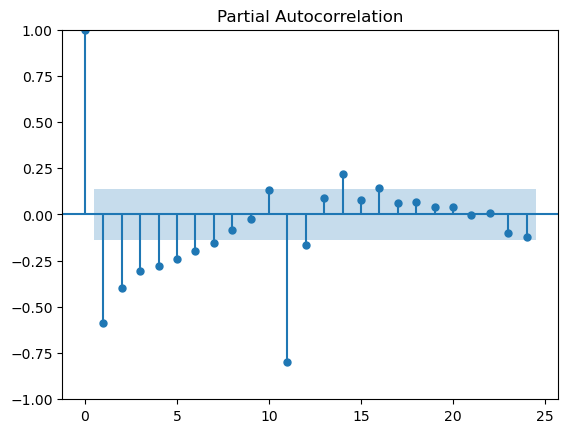

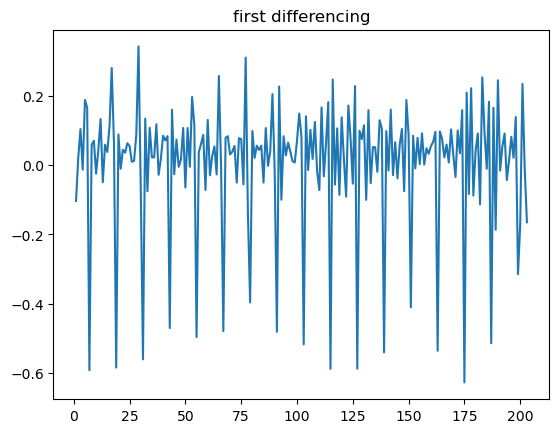

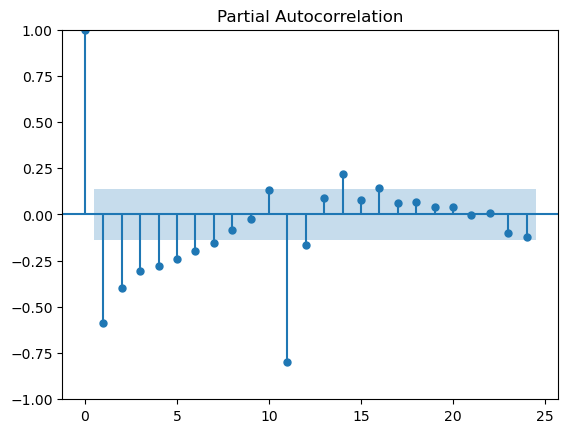

In [12]:
# PACF plot of 1st differenced log series
plt.plot(df.value.diff())
plt.title("first differencing")

plot_pacf(df.value.diff().diff().dropna())

## choix de q

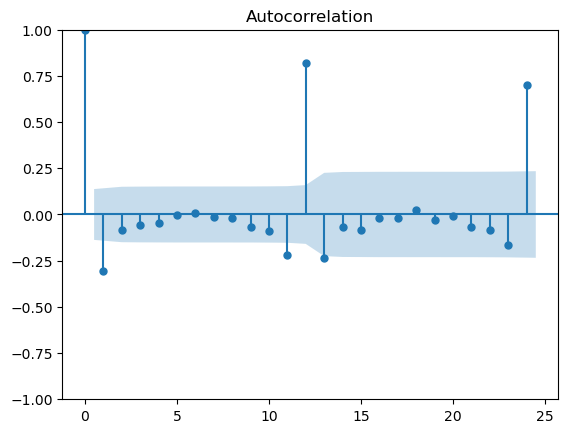

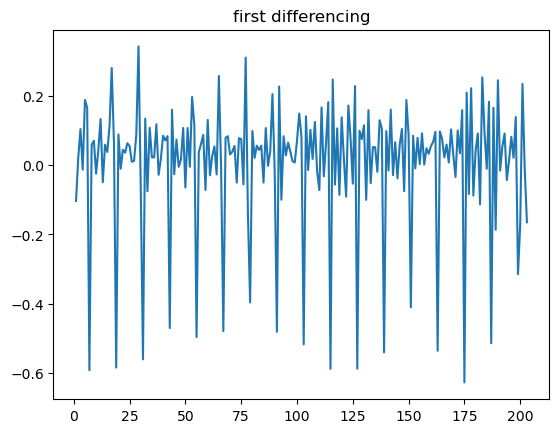

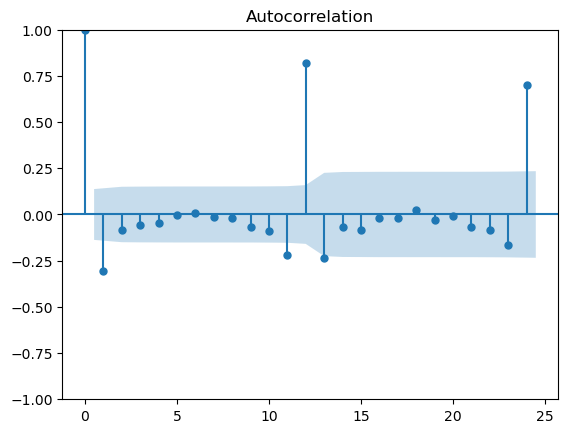

In [13]:
plt.plot(df.value.diff())
plt.title("first differencing")

plot_acf(df.value.diff().dropna())

## mise en place arima

In [14]:
# (p = 1, d = 1, q = 1) ARIMA Model
model1 = ARIMA(df.value, order=(1,1,1))
model_fit1 = model1.fit()
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  82.829
Date:                Mon, 27 Jan 2025   AIC                           -159.658
Time:                        21:54:52   BIC                           -149.719
Sample:                             0   HQIC                          -155.637
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3360      0.154      2.175      0.030       0.033       0.639
ma.L1         -0.8327      0.081    -10.292      0.000      -0.991      -0.674
sigma2         0.0258      0.002     10.332      0.0

In [15]:
# (p = 1, d = 1, q = 2) ARIMA Model
model2 = ARIMA(df.value, order=(1,1,2))
model_fit2 = model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  82.849
Date:                Mon, 27 Jan 2025   AIC                           -157.698
Time:                        21:54:52   BIC                           -144.445
Sample:                             0   HQIC                          -152.336
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2994      0.421      0.710      0.477      -0.527       1.125
ma.L1         -0.7924      0.432     -1.836      0.066      -1.639       0.054
ma.L2         -0.0314      0.301     -0.104      0.9

## graphique arima1 et arima2

In [16]:
df = pd.read_csv("data/dataset.csv")

df["log(value)"] = np.log(df['value'])
df["arima(1,1,1)"] = model_fit1.predict()
df["arima(1,1,2)"] = model_fit2.predict()
df["exp_arima(1,1,1)"] = np.exp(df["arima(1,1,1)"])
df["exp_arima(1,1,2)"] = np.exp(df["arima(1,1,2)"])

df.head()

date     value  log(value)  arima(1,1,1)  arima(1,1,2)  \
0  1991-07-01  3.526591    1.260332      0.000000      0.000000   
1  1991-08-01  3.180891    1.157161      1.260332      1.260332   
2  1991-09-01  3.252221    1.179338      1.189711      1.188978   
3  1991-10-01  3.611003    1.283986      1.194296      1.195069   
4  1991-11-01  3.565869    1.271408      1.250688      1.251415   

   exp_arima(1,1,1)  exp_arima(1,1,2)  
0          1.000000          1.000000  
1          3.526591          3.526591  
2          3.286132          3.283724  
3          3.301232          3.303786  
4          3.492744          3.495285

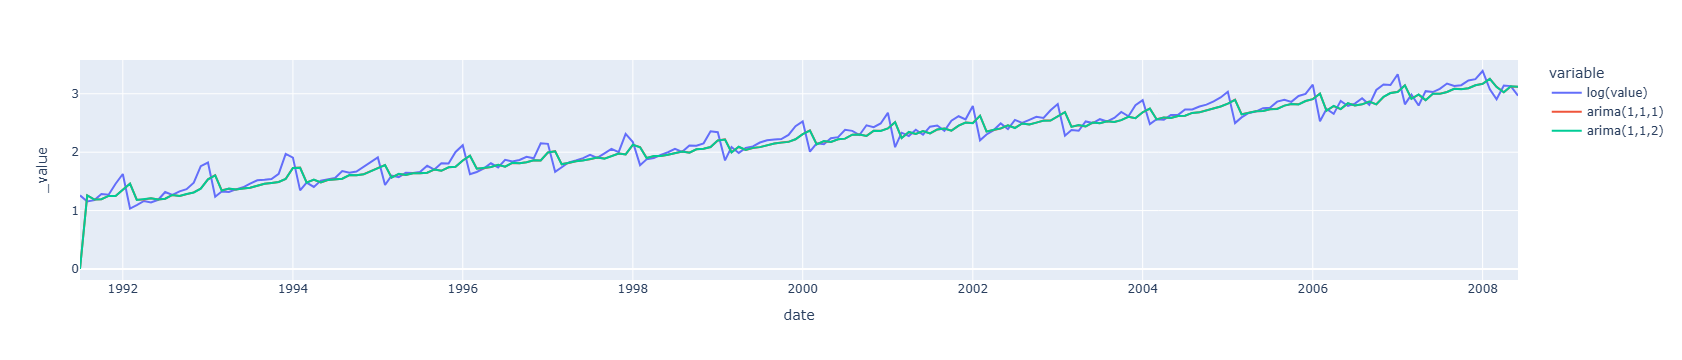

In [17]:
px.line(df, x= "date", y = ["log(value)", "arima(1,1,1)", "arima(1,1,2)"])

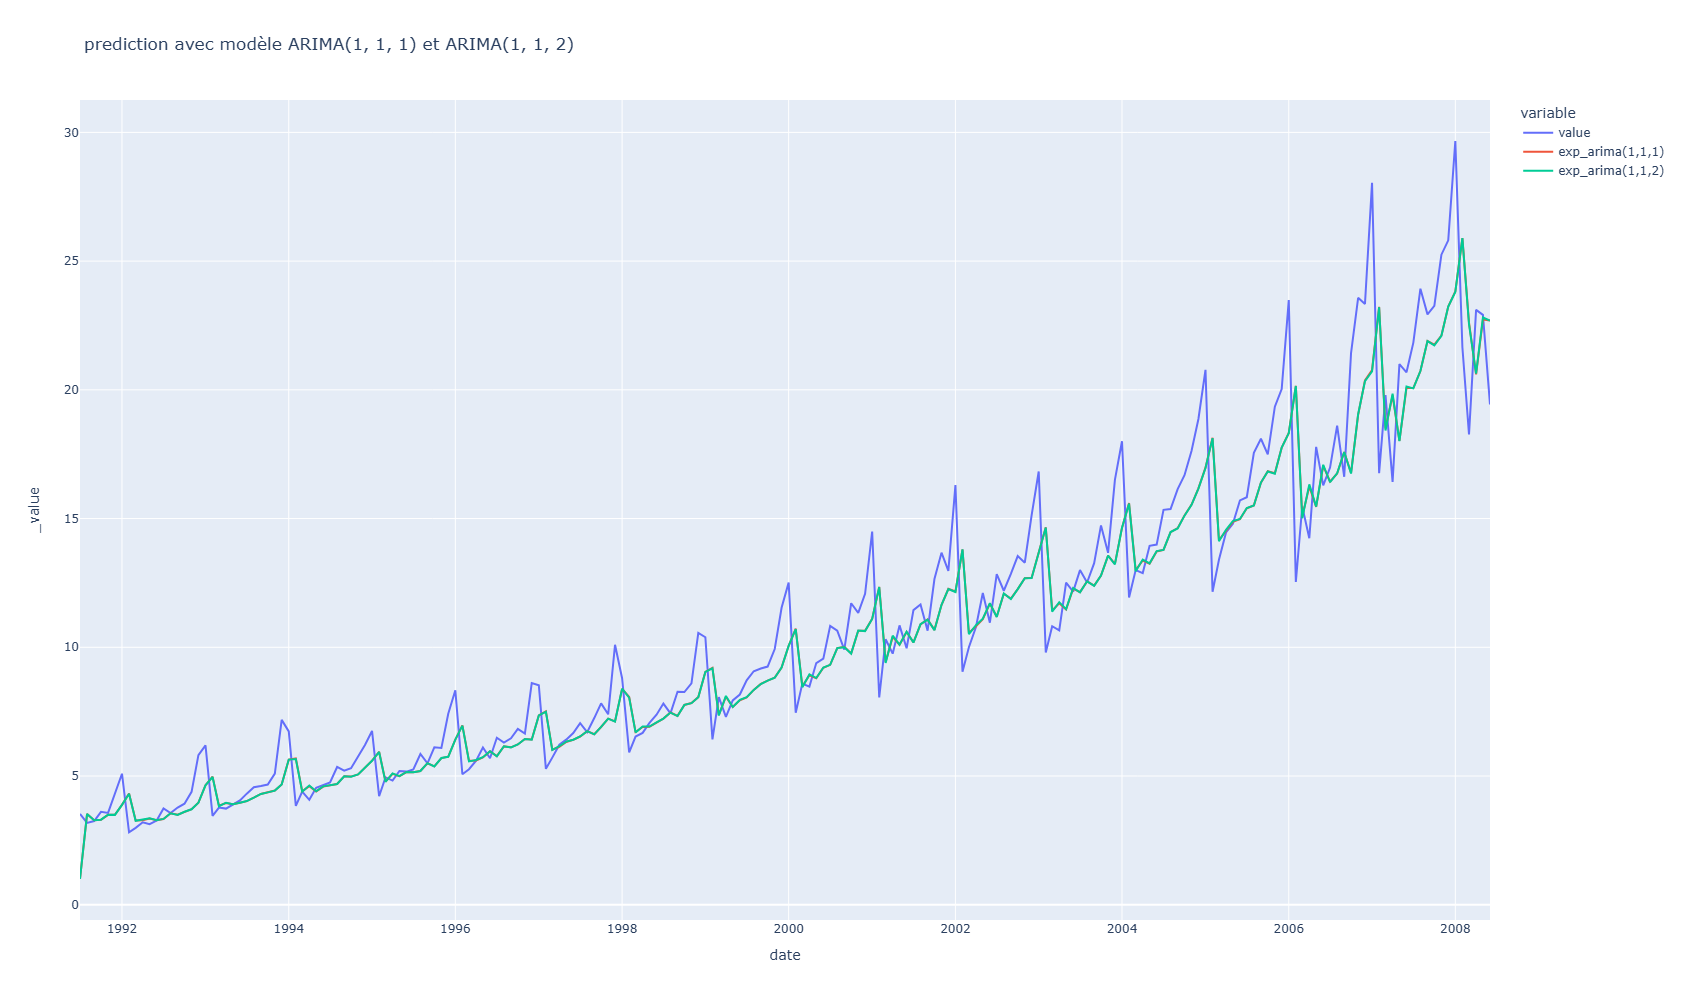

In [18]:
px.line(df, x= "date", y = ["value", "exp_arima(1,1,1)", "exp_arima(1,1,2)"], height= 1000, title="prediction avec modèle ARIMA(1, 1, 1) et ARIMA(1, 1, 2)")